#### 4. The Randomized Benchmarking Protocol

C:\Users\jayda\AppData\Local\Temp\ipykernel_7540\2347301805.py:53: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = backend.run(qobj).result()


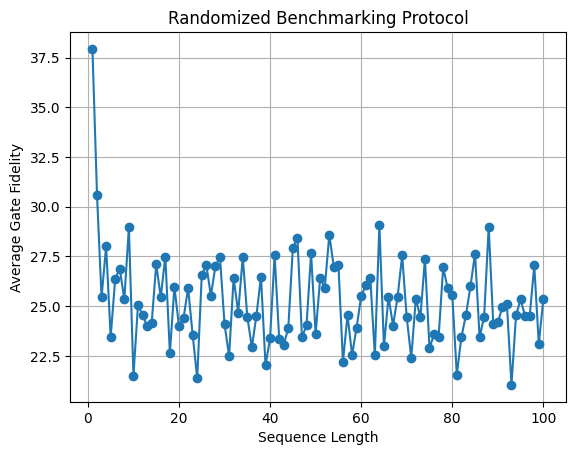

In [1]:
from qiskit import QuantumCircuit, transpile, assemble, Aer
import numpy as np
import matplotlib.pyplot as plt

# Function to generate a random single-qubit Clifford gate
def random_single_qubit_clifford():
    rand_gate = np.random.randint(24)  # 24 different Clifford gates
    qc = QuantumCircuit(1)
    if rand_gate < 8:
        qc.h(0)
        if rand_gate % 2 == 1:
            qc.s(0)
        if rand_gate % 4 == 3:
            qc.sdg(0)
    else:
        qc.s(0)
        qc.h(0)
        if rand_gate % 4 == 2:
            qc.sdg(0)
    return qc.to_gate()

# Function to create a random sequence of Clifford gates
def random_clifford_sequence(num_qubits, length):
    sequence = QuantumCircuit(num_qubits)
    for _ in range(length):
        sequence.append(random_single_qubit_clifford(), range(num_qubits))
    return sequence

# Function to perform randomized benchmarking on a single qubit
def randomized_benchmarking(num_qubits, num_sequences, max_sequence_length):
    backend = Aer.get_backend('qasm_simulator')

    gate_fidelities = []
    sequence_lengths = range(1, max_sequence_length + 1)

    for length in sequence_lengths:
        avg_success_prob = 0

        for _ in range(num_sequences):
            # Create the sequence of random Cliffords
            rb_circuit = random_clifford_sequence(num_qubits, length)

            # Add final Clifford gates (inverse of the initial sequence) for error mitigation
            inverse_clifford = random_clifford_sequence(num_qubits, length).inverse()
            rb_circuit &= inverse_clifford

            # Measure the final state
            rb_circuit.measure_all()

            # Execute the randomized benchmarking circuit
            t_circ = transpile(rb_circuit, backend)
            qobj = assemble(t_circ, shots=1024)
            result = backend.run(qobj).result()

            # Calculate the success probability (average fidelity)
            success_prob = result.get_counts(rb_circuit).get('0' * num_qubits, 0) / 1024
            avg_success_prob += success_prob

        # Calculate the average gate fidelity (normalized to Clifford fidelity)
        gate_fidelity = avg_success_prob / (2 ** num_qubits - 1)
        gate_fidelities.append(gate_fidelity)

    return sequence_lengths, gate_fidelities

if __name__ == "__main__":
    num_qubits = 1  # Number of qubits (can be adjusted for multi-qubit systems)
    num_sequences = 50  # Number of random sequences for each sequence length
    max_sequence_length = 100  # Maximum sequence length for benchmarking

    sequence_lengths, gate_fidelities = randomized_benchmarking(num_qubits, num_sequences, max_sequence_length)

    # Plot the results
    plt.plot(sequence_lengths, gate_fidelities, marker='o')
    plt.xlabel('Sequence Length')
    plt.ylabel('Average Gate Fidelity')
    plt.title('Randomized Benchmarking Protocol')
    plt.grid()
    plt.show()
